# Machine Learning Layer
#### Goal: Estimate the next beta

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf as tf
from plotnine import *
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

import pickle
import joblib

## 1) Import Data:
CSV file can be found in Teams under Model/ML_for_Beta/all_matrix_data.csv

In [3]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data_v3.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
df.sort_values('beta')

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
26714,20,58.802857,Other,7.285714,19.628571,4.685714,2.295918,2.300318e-20,3.791096e-01,2020-08-03,Potsdam-Mittelmark
13541,7,69.342857,Other,-19.428571,11.814286,7.542857,1.857143,2.643845e-20,4.575471e-01,2020-05-04,Oberhavel
33754,10,57.780000,Other,-6.714286,15.714286,8.885714,2.612245,7.766189e-20,4.148546e-01,2020-05-25,Rhein-Sieg-Kreis
16179,13,57.440000,Other,-4.571429,14.614286,10.914286,1.622449,1.251294e-19,6.060050e-01,2020-06-15,Aichach-Friedberg
36007,7,69.342857,Other,-25.142857,11.585714,10.914286,4.438776,2.907199e-18,1.451629e-01,2020-05-04,Essen
...,...,...,...,...,...,...,...,...,...,...,...
28403,17,58.804286,Other,9.285714,13.657143,13.928571,0.744898,3.923493e+00,5.671122e-07,2020-07-13,"Schwerin, Landeshauptstadt"
10407,69,73.210000,B.1.617.2,17.000000,17.714286,7.914286,0.663265,4.167030e+00,4.618029e-07,2021-07-12,Regen
32632,16,63.390000,Other,-6.000000,19.671429,NaN,1.959184,4.254476e+00,5.866944e-07,2020-07-06,Main-Tauber-Kreis
4151,17,58.804286,Other,-4.714286,13.414286,NaN,2.030612,4.266171e+00,5.615672e-07,2020-07-13,"Hof, Kreis"


## 2) Visualize Data:
#### 2.1) Average Infections (training period):

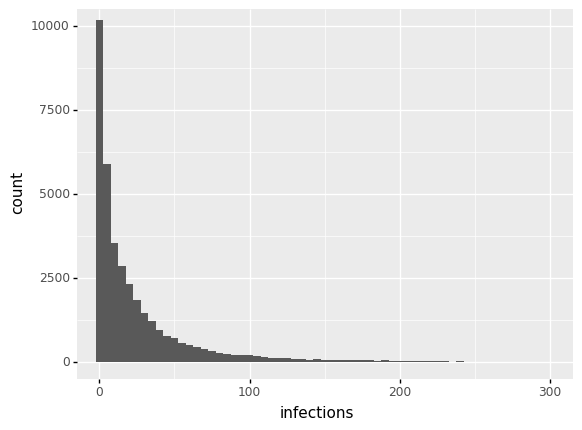

<ggplot: (381081591)>

In [5]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,300),ylim=(0,10000))

#### 2.2) Fitted beta:

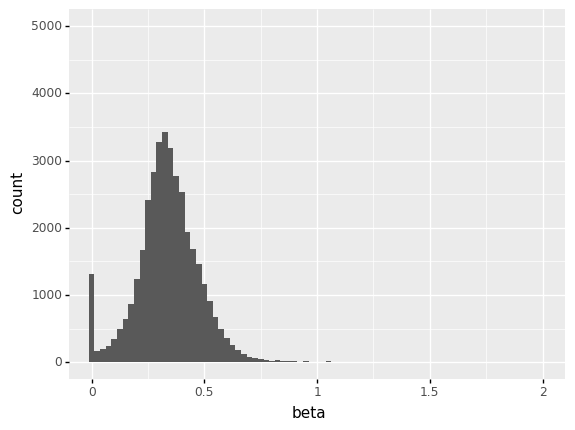

<ggplot: (381139815)>

In [6]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

#### 2.3) Average infections Münster

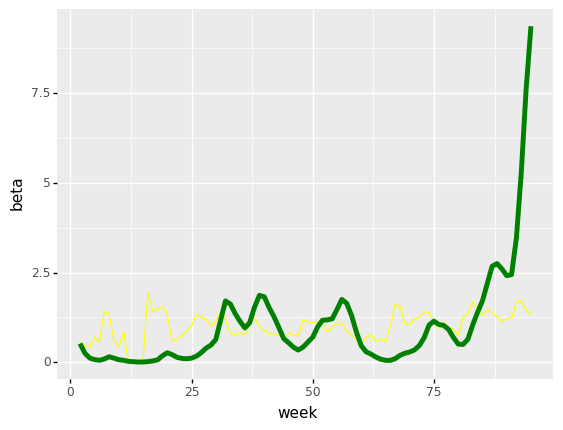

<ggplot: (381031653)>

In [7]:
district = 'Münster'
df_v2_3 = df[df['district']==district][['week','district','infections','beta']]

# Devide both columns by their mean so that they fit in one plot:
df_v2_3['infections'] = df_v2_3['infections']/df_v2_3['infections'].mean()
df_v2_3['beta'] = df_v2_3['beta']/df_v2_3['beta'].mean()

ggplot(df_v2_3) \
+ geom_line(aes(x='week', y='beta'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

#### 2.4) Policy index vs infections: (Germany)

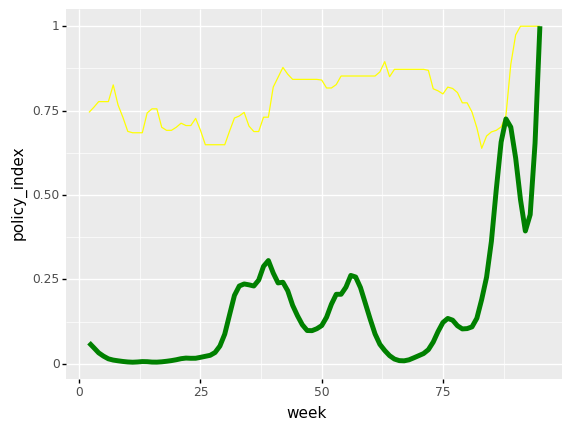

<ggplot: (381230436)>

In [8]:
df_v2_4 = df.groupby('week').sum()

# Devide both columns by their max so that they fit in one plot:
df_v2_4['infections'] = df_v2_4['infections']/df_v2_4['infections'].max()
df_v2_4['policy_index'] = df_v2_4['policy_index']/df_v2_4['policy_index'].max()

ggplot(df_v2_4.reset_index())\
+ geom_line(aes(x='week', y='policy_index'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

## 3) Feature Engineering:
#### Lagged beta: (NO LONGER NECESSARY!)

In [9]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [10]:
# Check out correlation between current and previous weeks beta:
df['beta'].corr(df['beta_t_minus_1'] )

-0.05990876887471662

## 4) Data cleaning:
#### Identify missing values:

In [11]:
df.isnull().sum()

week                         0
policy_index                 0
variant                      0
mobility                     0
temperature                236
wind                      3739
infections                   0
beta                         0
beta_t_minus_1               0
start_date_forecasting       0
district                     0
dtype: int64

#### Fill missing values with previous column:
Forward fill: Fill down (-> if missing value in week 50 use value of week 49)

In [12]:
df_v4 = df.copy()

In [13]:
df_v4['temperature'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['temperature']
df_v4['wind'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['wind']

/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_22904/1409488165.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_22904/1409488165.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.


In [14]:
df_v4

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
6580,2,62.500000,Other,-41.714286,5.171429,15.042316,52.469388,0.300629,0.339530,2020-03-30,Aachen
6581,3,63.778571,Other,-34.428571,5.914286,11.157143,36.877551,0.205305,0.351514,2020-04-06,Aachen
6582,4,65.180000,Other,-29.285714,15.071429,10.571429,25.244898,0.226196,0.214683,2020-04-13,Aachen
6583,5,65.180000,Other,-32.857143,11.085714,11.071429,16.683673,0.232024,0.210121,2020-04-20,Aachen
6584,6,65.180000,Other,-23.714286,13.500000,17.157143,8.091837,0.127777,0.272082,2020-04-27,Aachen
...,...,...,...,...,...,...,...,...,...,...,...
22743,91,83.930000,B.1.617.2,-2.571429,0.428571,8.528571,305.418367,0.327476,0.349327,2021-12-13,Zwickau
22744,92,83.930000,B.1.617.2,-1.000000,4.842857,10.485714,202.969388,0.287899,0.345975,2021-12-20,Zwickau
22745,93,83.930000,B.1.617.2,-4.285714,-1.200000,10.700000,143.653061,0.329843,0.289999,2021-12-27,Zwickau
22746,94,83.930000,B.1.1.529,-15.714286,7.871429,16.885714,107.020408,0.331757,0.326808,2022-01-03,Zwickau


## 5) Outlier removal:


In [15]:
# Identify outliers:

In [16]:
df_v4[df_v4['infections'] > 20].sort_values('beta_t_minus_1', ascending=True)

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
33129,43,71.985714,B.1.1.7,-15.714286,-1.585714,8.928571,76.775510,0.284688,0.106589,2021-01-11,Vogtlandkreis
2393,45,70.710000,Other,-0.142857,2.742857,18.042857,38.428571,0.317974,0.115837,2021-01-25,Mansfeld-Südharz
37264,42,73.690000,Other,-23.000000,-2.485714,5.785714,21.530612,0.407612,0.136652,2021-01-04,Oberallgäu
21188,40,68.790000,B.1.1.7,-30.714286,4.871429,14.228571,48.122449,0.595043,0.141463,2020-12-21,Potsdam
15553,45,70.710000,Other,-18.000000,4.814286,14.385714,38.744898,0.233008,0.148055,2021-01-25,Bielefeld
...,...,...,...,...,...,...,...,...,...,...,...
28852,90,81.761429,B.1.617.2,4.000000,2.657143,15.685714,302.653061,0.453113,0.887275,2021-12-06,Börde
10151,95,83.930000,B.1.1.529,1.000000,3.157143,11.157143,312.244898,0.397794,0.929834,2022-01-10,"Lübeck, Hansestadt"
33006,14,62.370000,Other,-4.714286,17.928571,8.514286,75.244898,0.103622,0.932201,2020-06-22,Gütersloh
1251,31,57.865714,Other,21.000000,6.871429,9.369137,22.510204,0.358205,1.036735,2020-10-19,Altenkirchen (Ww)


#### 5.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [17]:
# Drop all rows in which average number of infections is below 5:
threshold = 20
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 5.2) Beta values:

In [18]:
# Drop all rows in which the beta value is < 0.025:
threshold = 0.025
df_v5_2 = df_v5_1[df_v5_1['beta'] > threshold]

In [19]:
# correlation:
df_v5_2['beta'].corr(df_v5_2['beta_t_minus_1'] )

0.45584436210317486

## 6) Preprocessing columns:


#### 6.1) Handling categorical columns:

In [20]:
# Only use week and district as index columns:
df_v6_1 = df_v5_2.set_index(['week','district','start_date_forecasting'])

In [21]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [22]:
# Drop "other" variant column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

#### 6.2) Standardizing:

In [23]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df_v6_2_d.drop(columns=['beta'], axis=1)
beta_cols = df_v6_2_d[['beta']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df_v6_3 = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)

## 7) Modeling
### 7.1) Preparation
#### 7.1.1) Split into train/val:

In [121]:
df_full = df_v6_3
df_full

,,,B.1.1.529,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,beta
week,district,start_date_forecasting,,,,,,,,,,
2,Aachen,2020-03-30,-0.243679,-0.643412,-0.780464,-0.703683,-2.651919,-0.205922,0.905543,-0.171991,-0.475700,0.300629
3,Aachen,2020-04-06,-0.243679,-0.643412,-0.780464,-0.556133,-2.140381,-0.055050,-0.104176,-0.299066,-0.355522,0.205305
4,Aachen,2020-04-13,-0.243679,-0.643412,-0.780464,-0.394405,-1.779296,1.804743,-0.256398,-0.393874,-1.727688,0.226196
28,Aachen,2020-09-28,-0.243679,-0.643412,-0.780464,-1.631516,0.367155,1.619054,0.805440,-0.379487,-0.626513,0.414793
29,Aachen,2020-10-05,-0.243679,-0.643412,-0.780464,-1.631516,0.517608,1.352126,0.690346,-0.207253,0.235502,0.461583
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Zwickau,2021-12-13,-0.243679,-0.643412,1.281290,1.769387,0.096342,-1.169184,-0.787317,1.889576,-0.377459,0.327476
92,Zwickau,2021-12-20,-0.243679,-0.643412,1.281290,1.769387,0.206673,-0.272654,-0.278674,1.054604,-0.411073,0.287899
93,Zwickau,2021-12-27,-0.243679,-0.643412,1.281290,1.769387,-0.024020,-1.499943,-0.222983,0.571168,-0.972410,0.329843


In [122]:
# Sample 1500 row out of last weeks available for training:
sample_size = 1500
max_week = max(df_full.index.get_level_values('week'))

random_indices = df_full[df_full.index.get_level_values('week') >= max_week-5].sample(sample_size).index

In [123]:
df_test = df_full.loc[df_full.index.isin(random_indices)]
df_modeling = df_full.loc[~df_full.index.isin(random_indices)]

#### 7.1.2) Split into train, val and test:

In [124]:
SEED = 420

In [125]:
X_full_modeling = df_modeling.drop(columns=['beta'], axis=1)
y_full_modeling = df_modeling['beta']

X_test = df_test.drop(columns=['beta'], axis=1)
y_test = df_test['beta']

In [126]:
# Train and Val:
X_train, X_val, y_train, y_val = train_test_split(X_full_modeling, y_full_modeling, shuffle=True, train_size=0.75, random_state=SEED)

### 7.2 Models
#### 7.2.1) Baseline Approach: Choosing previous beta

In [127]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:

# As the values are standardized we have to reverse standardize them first:
y_pred_baseline_val = pd.DataFrame(scaler_obj.inverse_transform(X_val), index=X_val.index, columns=X_val.columns)['beta_t_minus_1']

In [128]:
# Correlation of this approach:
y_pred_baseline_val.corr(y_val)

0.5100415580805281

In [129]:
pd.DataFrame({'y_val':y_val, 'y_pred_baseline':y_pred_baseline_val})

,,,y_val,y_pred_baseline
week,district,start_date_forecasting,,
55,Bremerhaven,2021-04-05,0.293451,0.266345
39,Rotenburg (Wümme),2020-12-14,0.310055,0.360803
45,Schwalm-Eder,2021-01-25,0.294304,0.364152
81,Vorpommern-Rügen,2021-10-04,0.323457,0.504445
40,Heinsberg,2020-12-21,0.302554,0.307872
...,...,...,...,...
55,Reutlingen,2021-04-05,0.335680,0.337460
90,Straubing-Bogen,2021-12-06,0.273998,0.286062
50,Solingen,2021-03-01,0.270564,0.373545


In [130]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline_val, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 0.09505799900600805


#### 7.2.2) Multivariate Linear Regression

In [131]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [132]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 0.06131638766641736. This is an improvement compared to the baseline approach of: 35.495814862942865 %


#### 7.2.3) Ridge Regression:

In [133]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train, y_train)

y_pred_ridge_reg = ridge_reg.predict(X_val)
rmse_ridge_reg = mean_squared_error(y_val, y_pred_ridge_reg, squared=False)

In [134]:
print(f'RMSE of {ridge_reg} is: {rmse_ridge_reg}. This is an improvement compared to the baseline approach of: {-(rmse_ridge_reg / rmse_baseline -1)*100} %')

RMSE of Ridge() is: 0.06131592697647359. This is an improvement compared to the baseline approach of: 35.49629950384483 %


#### 7.2.4) Random Forest Regressor:

In [135]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [136]:
print(f'RMSE of {rfg_model} is: {rmse_random_forest}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 0.05117363435353169. This is an improvement compared to the baseline approach of: 46.16588305178051 %


#### 7.2.5) Support Vector Machines

In [137]:
svm = SVR()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)
rmse_svm = mean_squared_error(y_val, y_pred_svm, squared=False)

In [138]:
print(f'RMSE of {svm} is: {rmse_svm}. This is an improvement compared to the baseline approach of: {-(rmse_svm / rmse_baseline -1)*100} %')

RMSE of SVR() is: 0.05871208532625408. This is an improvement compared to the baseline approach of: 38.23551311810882 %


#### 7.2.6) XGBoost

In [139]:
xgb_model = xgb.XGBRegressor(verbosity=0)
xgb_model.name = 'XGBoostRegressor'
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

In [140]:
print(f'\n RMSE of {xgb_model.name} is: {rmse_xgb}. This is an improvement compared to the baseline approach of: {-(rmse_xgb / rmse_baseline -1)*100} %')


 RMSE of XGBoostRegressor is: 0.05269516876149724. This is an improvement compared to the baseline approach of: 44.5652451003448 %


In [141]:
pd.DataFrame({'beta_opt':y_val, 'last_beta':y_pred_baseline_val, 'last_beta_standardized':X_val['beta_t_minus_1'], 'xgb_pred':y_pred_xgb}).sort_values('start_date_forecasting', ascending=False)

beta_opt  last_beta  \
week district                   start_date_forecasting                        
95   Recklinghausen             2022-01-10              0.466727   0.484974   
     Landeshauptstadt Wiesbaden 2022-01-10              0.622669   0.589446   
     Euskirchen                 2022-01-10              0.500047   0.518305   
     Herne                      2022-01-10              0.630335   0.642132   
     Rheingau-Taunus            2022-01-10              0.573513   0.470809   
...                                                          ...        ...   
2    Hannover                   2020-03-30              0.278749   0.432434   
     Fürstenfeldbruck           2020-03-30              0.252177   0.564165   
     Schwäbisch Hall            2020-03-30              0.303848   0.459277   
     Paderborn                  2020-03-30              0.429052   0.360373   
     Düsseldorf                 2020-03-30              0.367956   0.262332   

                                                        last_beta_standardized  \
week district                   start_date_forecasting                           
95   Recklinghausen             2022-01-10                            0.982838   
     Landeshauptstadt Wiesbaden 2022-01-10                            2.030503   
     Euskirchen                 2022-01-10                            1.317084   
     Herne                      2022-01-10                            2.558851   
     Rheingau-Taunus            2022-01-10                            0.840791   
...                                                                        ...   
2    Hannover                   2020-03-30                            0.455953   
     Fürstenfeldbruck           2020-03-30                            1.776986   
     Schwäbisch Hall            2020-03-30                            0.725143   
     Paderborn                  2020-03-30                           -0.266681   
     Düsseldorf                 2020-03-30                           -1.249863   

                                                        xgb_pred  
week district                   start_date_forecasting            
95   Recklinghausen             2022-01-10              0.514669  
     Landeshauptstadt Wiesbaden 2022-01-10              0.531590  
     Euskirchen                 2022-01-10              0.490774  
     Herne                      2022-01-10              0.494596  
     Rheingau-Taunus            2022-01-10              0.528188  
...                                                          ...  
2    Hannover                   2020-03-30              0.353772  
     Fürstenfeldbruck           2020-03-30              0.339177  
     Schwäbisch Hall            2020-03-30              0.302387  
     Paderborn                  2020-03-30              0.319977  
     Düsseldorf                 2020-03-30              0.312688  

[3100 rows x 4 columns]

#### 7.2.7) Neural Network

In [142]:
ann_model = Sequential([
    Dense(24, input_dim=len(X_train.columns), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# compile model:
ann_model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics=[RootMeanSquaredError(name='rmse')]
)

In [143]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=20,
                        # class_weight=class_weight,
                        validation_data=(X_val, y_val),
                        )

Epoch 1/20
291/291 [==============================] - 1s 1ms/step - loss: 0.0567 - rmse: 0.2382 - val_loss: 0.0083 - val_rmse: 0.0910
Epoch 2/20
291/291 [==============================] - 0s 945us/step - loss: 0.0133 - rmse: 0.1155 - val_loss: 0.0055 - val_rmse: 0.0745
Epoch 3/20
291/291 [==============================] - 0s 948us/step - loss: 0.0081 - rmse: 0.0900 - val_loss: 0.0049 - val_rmse: 0.0697
Epoch 4/20
291/291 [==============================] - 0s 948us/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0045 - val_rmse: 0.0669
Epoch 5/20
291/291 [==============================] - 0s 946us/step - loss: 0.0056 - rmse: 0.0750 - val_loss: 0.0043 - val_rmse: 0.0659
Epoch 6/20
291/291 [==============================] - 0s 944us/step - loss: 0.0051 - rmse: 0.0713 - val_loss: 0.0040 - val_rmse: 0.0634
Epoch 7/20
291/291 [==============================] - 0s 938us/step - loss: 0.0049 - rmse: 0.0702 - val_loss: 0.0040 - val_rmse: 0.0631
Epoch 8/20
291/291 [==============================

In [144]:
y_pred_ann = ann_model.predict(X_val)
rmse_ann = mean_squared_error(y_val, y_pred_ann, squared=False)

In [145]:
print(f'RMSE of {ann_model} is: {rmse_ann}. This is an improvement compared to the baseline approach of: {-(rmse_ann / rmse_baseline -1)*100} %')

RMSE of <keras.engine.sequential.Sequential object at 0x16c6e1b50> is: 0.059128966308774386. This is an improvement compared to the baseline approach of: 37.796958775623715 %


## 8) Model Evaluation:

### Metric Computation:

#### Baseline:

In [146]:
y_pred_baseline_test = pd.DataFrame(scaler_obj.inverse_transform(X_test), index=X_test.index, columns=X_test.columns)['beta_t_minus_1']
rmse_baseline_test = mean_squared_error(y_pred_baseline_test, y_test, squared=False)
print(f'RMSE of baseline approach is: {rmse_baseline_test}')

RMSE of baseline approach is: 0.12026247005874394


#### Random Forest:

In [147]:
# Apply optimal model to testset:
y_pred_test_rf = rfg_model.predict(X_test)

rmse_rf_test = mean_squared_error(y_pred_test_rf, y_test, squared=False)
print(f'RMSE of {rfg_model} is: {rmse_rf_test}. This is an improvement compared to the baseline approach of: {-(rmse_rf_test / rmse_baseline_test -1)*100}%')

RMSE of RandomForestRegressor() is: 0.0801254396282486. This is an improvement compared to the baseline approach of: 33.374526908427725%


#### XGB Boost:

In [148]:
# Apply optimal model to testset:
y_pred_test_xgb = xgb_model.predict(X_test)

rmse_xgb_test = mean_squared_error(y_pred_test_xgb, y_test, squared=False)
print(f'RMSE of {xgb_model.name} is: {rmse_xgb_test}. This is an improvement compared to the baseline approach of: {-(rmse_xgb_test / rmse_baseline_test -1)*100}%')

RMSE of XGBoostRegressor is: 0.0827181426089507. This is an improvement compared to the baseline approach of: 31.218656519739007%


### Model comparison:

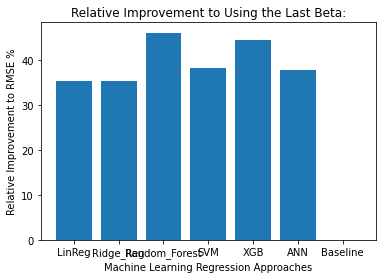

In [149]:
rmses_dict = {
    'LinReg': rmse_linreg,
    'Ridge_Reg': rmse_ridge_reg,
    'Random_Forest': rmse_random_forest,
    'SVM': rmse_svm,
    'XGB': rmse_xgb,
    'ANN':rmse_ann,
    'Baseline': rmse_baseline,
}

rmses_rel_improvement = {k:(-(v/rmse_baseline-1)*100) for (k,v) in rmses_dict.items()}
rmses_rel_improvement

plt.bar(x=rmses_rel_improvement.keys(),height=rmses_rel_improvement.values())
plt.title("Relative Improvement to Using the Last Beta:")
plt.xlabel(xlabel='Machine Learning Regression Approaches')
plt.ylabel(ylabel='Relative Improvement to RMSE %')
plt.show()

### Feature Importance:

<AxesSubplot:>

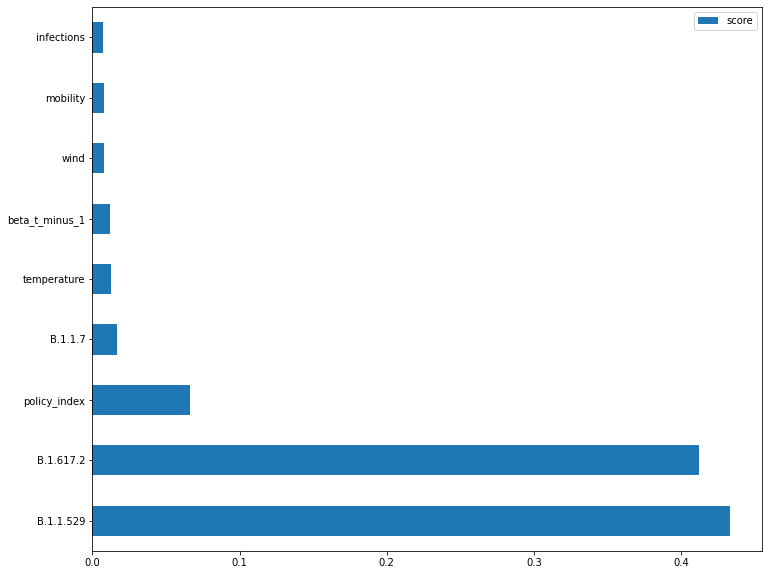

<AxesSubplot:>

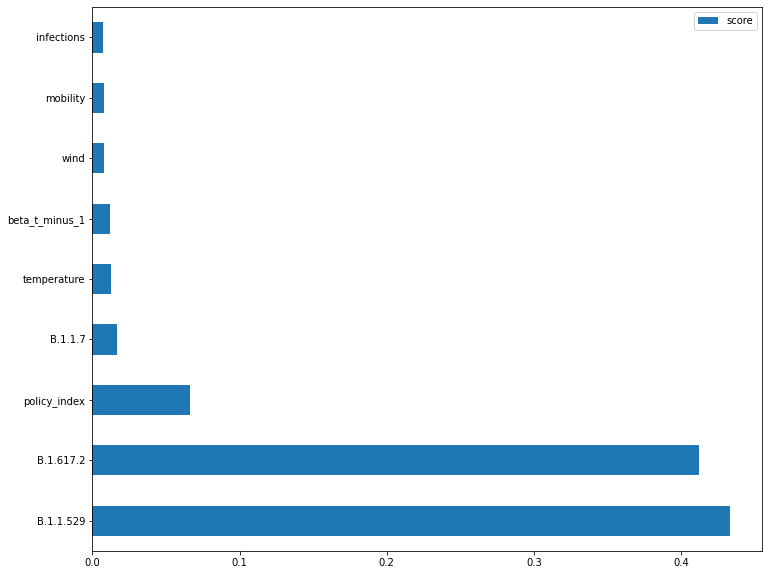

In [151]:
feature_important = xgb_model.get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (12,10)) ## plot top 40 features

In [152]:
perm_importance = permutation_importance(xgb_model, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

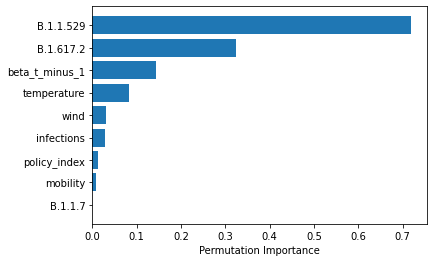

In [153]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Residual analysis:

In [157]:
residuals_df = pd.DataFrame({
    'beta_opt':y_test, 'last_beta_pred':y_pred_baseline_test, 'xgb_pred':y_pred_test_xgb,
    'residual_last_beta': y_pred_baseline_test-y_test,
    'residual_xgb_pred': y_pred_test_xgb-y_test,
})
residuals_df

,,,beta_opt,last_beta_pred,xgb_pred,residual_last_beta,residual_xgb_pred
week,district,start_date_forecasting,,,,,
90,Aachen,2021-12-06,0.363928,0.372051,0.375469,0.008123,0.011541
91,Aachen,2021-12-13,0.363211,0.368352,0.366538,0.005141,0.003328
92,Aachen,2021-12-20,0.424817,0.353813,0.362096,-0.071004,-0.062721
93,Aachen,2021-12-27,0.577887,0.356339,0.404142,-0.221548,-0.173745
94,Aachen,2022-01-03,0.586449,0.516768,0.461484,-0.069682,-0.124965
...,...,...,...,...,...,...,...
91,Zwickau,2021-12-13,0.327476,0.349327,0.400115,0.021851,0.072639
92,Zwickau,2021-12-20,0.287899,0.345975,0.366151,0.058076,0.078252
93,Zwickau,2021-12-27,0.329843,0.289999,0.458311,-0.039844,0.128468


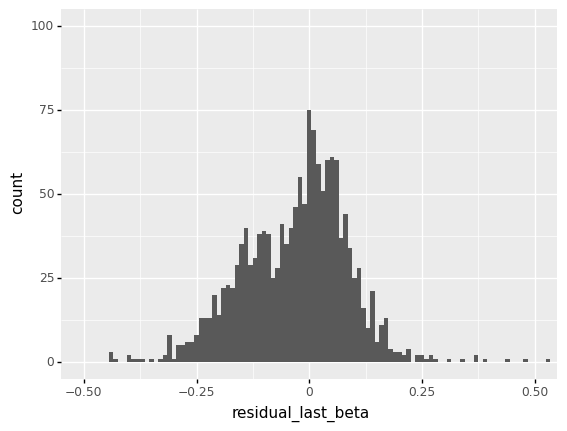

<ggplot: (385331237)>

In [161]:
## Plot residuals:
# Last Beta
ggplot(residuals_df, aes(x='residual_last_beta')) + geom_histogram(binwidth=0.01) + coord_cartesian(xlim=(-0.5,0.5),ylim=(0,100))

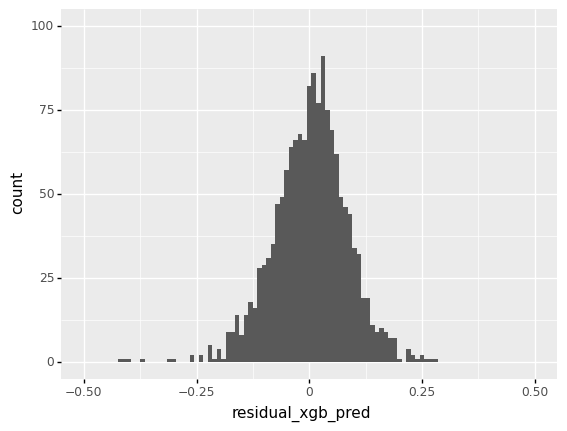

<ggplot: (385553562)>

In [163]:
# XGB Beta
ggplot(residuals_df, aes(x='residual_xgb_pred')) + geom_histogram(binwidth=0.01) + coord_cartesian(xlim=(-0.5,0.5),ylim=(0,100))

## 9) Export Best Model:

In [165]:
path = '../../../../Assets/MachineLearningLayer/Models/'
best_model = xgb_model

# ML Model:
filename = 'xgb_model_lukas.pkl'
combined_path = path+filename
joblib.dump(best_model, open(combined_path, 'wb'))

# Standardizer:
filename = 'standardizer_model.pkl'
combined_path = path+filename
joblib.dump(scaler_obj, open(path+filename, 'wb'))

print('succesfully exported')

succesfully exported
